# System Path & Modules

Only do this, if modules are not found

In [1]:
# import sys
# print('Set search paths')
# sys.path.append(path_to_modules) 

# Main Script

## Interpolate Original Data to Target Grid

Do everything for only one Dataset

### Load Original Data

In [3]:
#---
# Modules
#---
from eddies.data import data_loader
from eddies.grid import FESOM_grid
from eddies.grid import grid_transformer

#---------
# Original Data
#---------
path = path_to_your_data
grid = load_your_grid
xx0, yy0 = grid.elem_x, grid.elem_y # Original grid-coordinates

(u, udis, v, vdis) = data_loader.load_original_data(path) # Element-Structure

#---------
# Transform to matrix structure
#---------
u_matrix    = grid_transformer.elem_to_matrix(u, yy0)
v_matrix    = grid_transformer.elem_to_matrix(v, yy0)
udis_matrix = grid_transformer.elem_to_matrix(udis, yy0)
vdis_matrix = grid_transformer.elem_to_matrix(vdis, yy0)

### Interpolate to Regular Grid

In [5]:
#-------
# Interpolate data
#-------

#- Modules
import random
from eddies.grid import setup_grid
from eddies.interpolation import interpolator
from eddies.figures import plotter

#- Parameters
days   = 1 #- Number of days to analyze
lvls   = 1 #- Number of levels to analyze
xx     = xx0[:-228] #- Coordinates Original Grid. Omit last row for interpolation
yy     = yy0[:-228]
dx     = 0.01       #- Grid-Spacing Target Grid
dy     = 0.01
lx     = 4.5        #- Dimensions of Target Grid
ly     = 18.0 
method = 'linear'   #- Interpolation method

#- Setup Target Grid
eps1 = round(random.uniform(0, .09), ndigits=4) # Randomize starting points
eps2 = round(random.uniform(0, .05), ndigits=4)
sx = 0.0083 # eps1 #- Starting points
sy = 0.0263 # eps2
XX1, YY1 = setup_grid.regular_grid(lx=lx, ly=ly, dx=dx, dy=dy, sx=sx, sy=sy) 

#- Crop Target grid within original coordinates
ny_min = min(np.where(np.unique(YY1) > np.min(yy0))[0])
ny_max = max(np.where(np.unique(YY1) < np.max(yy0))[0])
nx_min = min(np.where(np.unique(XX1) > np.min(xx0))[0])
nx_max = max(np.where(np.unique(XX1) < np.max(xx0))[0])

XX1 = XX1[ny_min:ny_max, nx_min:nx_max]
YY1 = YY1[ny_min:ny_max, nx_min:nx_max]

#- Interpolation
u_int    = interpolator.interpolate_to_grid(u[:,:-228,:], xx, yy, XX1, YY1, days, lvls, method)
v_int    = interpolator.interpolate_to_grid(v[:,:-228,:], xx, yy, XX1, YY1, days, lvls, method)
udis_int = interpolator.interpolate_to_grid(udis[:,:-228,:], xx, yy, XX1, YY1, days, lvls, method)
vdis_int = interpolator.interpolate_to_grid(vdis[:,:-228,:], xx, yy, XX1, YY1, days, lvls, method)

#- Check for NaN-Values
print(f'NaN-Values in u_int: {np.isnan(u_int).sum()}')

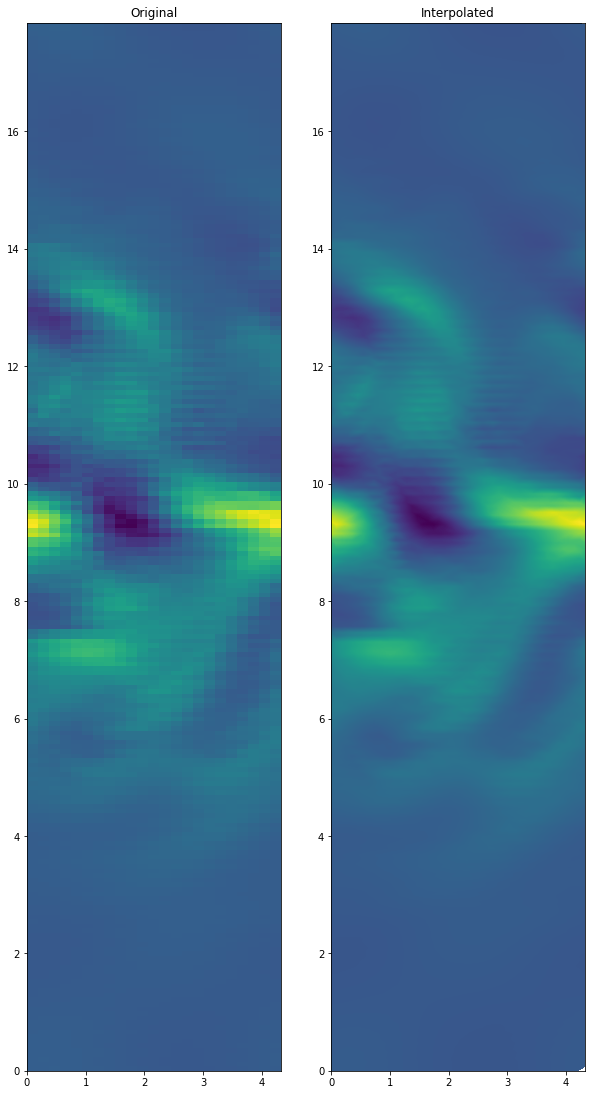

In [6]:
#---
# Plot Original and Interpolated Grid
#---
day = 0
lvl = 0
fig1 = plotter.compare_original_interpolated(u_matrix[:,:,:-1,:lvls], u_int, day, lvl, xx, yy) # Last row omitted in interpolation.

### Save Interpolated Values to Disk

In [12]:
from eddies.data import data_saver
folder = '../resources/interpolated_data/'
f1,f2,f3,f4 = data_saver.save_interpolated_values(u_int, udis_int, v_int, vdis_int, 
                                                  year=year, scheme=scheme, 
                                                  dx=dx, dy=dy, sx=sx, sy=sy, 
                                                  folder=folder, method=method
                                                 )

## Analyze Interpolated Data using 2D-FFT

### Load Original Data as shown above

### Load interpolated values from disk and preprocess it

In [11]:
#---
# Modules
#---
from eddies.interpolation import interpolation_tools
from eddies.interpolation import interpolation_tools
from eddies.figures import plotter

#---
# Load interpolated data
# Make sure it is the same year as original data
#---

method = 'linear'
filled = 'filled_boarders'
f1 = '../resources/interpolated_data/u'   + '_' + scheme + '_' + str(year) + '_0c01_0c01_0c0083_0c0263_' + method + '_' + filled  
f2 = '../resources/interpolated_data/udis'+ '_' + scheme + '_' + str(year) + '_0c01_0c01_0c0083_0c0263_' + method + '_' + filled
f3 = '../resources/interpolated_data/v'   + '_' + scheme + '_' + str(year) + '_0c01_0c01_0c0083_0c0263_' + method + '_' + filled
f4 = '../resources/interpolated_data/vdis'+ '_' + scheme + '_' + str(year) + '_0c01_0c01_0c0083_0c0263_' + method + '_' + filled
u_int    = np.load(f1 + '.npy')
udis_int = np.load(f2 + '.npy')
v_int    = np.load(f3 + '.npy')
vdis_int = np.load(f4 + '.npy')

#- Parameters of interpolated data
days = u_int.shape[0]
ny   = u_int.shape[1]
nx   = u_int.shape[2]
nz   = u_int.shape[3]

#- Fill boarders
u_int    = interpolation_tools.fill_boarders(u_int)
v_int    = interpolation_tools.fill_boarders(v_int)
udis_int = interpolation_tools.fill_boarders(udis_int)
vdis_int = interpolation_tools.fill_boarders(vdis_int)

#- Cut NaN Values out
u_int    = interpolation_tools.cut_boarders(u_int)
v_int    = interpolation_tools.cut_boarders(v_int)
udis_int = interpolation_tools.cut_boarders(udis_int)
vdis_int = interpolation_tools.cut_boarders(vdis_int)

#- Apply Hanning Window if necessary
is_hw = False
if is_hw: 
    u_int    = interpolation_tools.apply_hanning_window(u_int   , axis=1)
    v_int    = interpolation_tools.apply_hanning_window(v_int   , axis=1)
    udis_int = interpolation_tools.apply_hanning_window(udis_int, axis=1)
    vdis_int = interpolation_tools.apply_hanning_window(vdis_int, axis=1)

### Compare fields before applying 2D-FFT

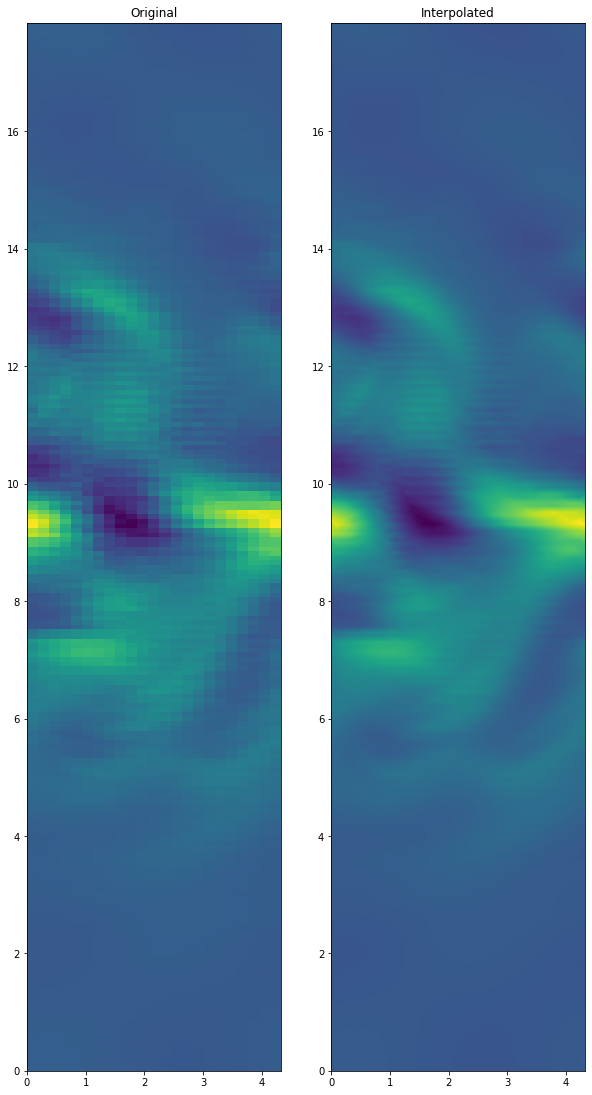

In [10]:
day = 0
lvl = 0
nz  = 1
fig1 = plotter.compare_original_interpolated(u_matrix[:,:,:-1,:nz], u_int, day, lvl, xx, yy) # Last row omitted in interpolation.
fig1.show()

### Apply 2D-FFT

In [11]:
#---
# Modules
#---
from eddies.diagnostics import spectra
from eddies.data import data_saver
from eddies.interpolation import interpolation_tools

#---
# Calculate and collapse 2D-Spectrum
#---
(ske_collapsed, sd_collapsed, kkarr) = spectra.get_2D_spectrum(u_int, v_int, udis_int, vdis_int)

In [6]:
# #---
# # Save collapsed 2D-Spectrum
# #---
# # Parameters
# dx = 0.01
# dy = 0.01 
# sx = 0.0083
# sy = 0.0263
# year = 1950
# #scheme = 'Leith'
# folder = '../resources/collapsed_2D_spectra/'
# method = 'linear'
# is_hw = False

# # Saving
# data_saver.save_collapsed_spectra(ske_collapsed, sd_collapsed, year, scheme, dx, dy, sx, sy, folder, method, is_hw)

### Plot collapsed spectra of 2D-FFT

In [15]:
#---
# Load collapsed 2D-Spectra
#---
folder = '../resources/collapsed_2D_spectra/'
dis1    = np.load(folder + 'collapsed2D_DIS_Easy4_1950_0c01_0c01_0c0083_0c0263_nearest_filled_boarders.npy') # shape: (days, dis, nz)
ke1     = np.load(folder + 'collapsed2D_KE_Easy4_1950_0c01_0c01_0c0083_0c0263_nearest_filled_boarders.npy')
dis2    = np.load(folder + 'collapsed2D_DIS_Leith_1950_0c01_0c01_0c0083_0c0263_nearest_filled_boarders.npy') 
ke2     = np.load(folder + 'collapsed2D_KE_Leith_1950_0c01_0c01_0c0083_0c0263_nearest_filled_boarders.npy') 

#------------
# Settings
#------------
import matplotlib.pyplot as plt
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
day    = 0
nz     = 0

#------------
# Plot
#------------

#- Values: Skipping k=0
y1 = np.mean(ke1,  axis=(0,2))[:] #- Scheme1
y2 = np.mean(dis1, axis=(0,2))[:]
y3 = np.mean(ke2,  axis=(0,2))[:] #- Scheme2
y4 = np.mean(dis2, axis=(0,2))[:]
xx = np.arange(len(y1))

#- Figure Settings
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.suptitle('Collapsed 2D-Spectrum')

#-----------
# Scheme1
#-----------
#- Kinetic Energy
ax[0].plot(xx, y1, linestyle= '-', color=colors[0], label='Easy4')
ax[0].plot(xx, xx**-(5/3) / 10**2, color=colors[4], alpha=.3)
ax[0].plot(xx, xx**-(3.0) / 10**2, color=colors[5], alpha=.3)


#- Dissipation
ax[1].plot(xx, y2, linestyle= '-',  color=colors[0], label='Easy4')

#-----------
# Scheme2
#-----------
#- Kinetic Energy
ax[0].plot(xx, y3, linestyle= '-', color=colors[1], label='Leith')
ax[0].plot(xx, xx**-(5/3) / 10**2, color=colors[4], alpha=.3)
ax[0].plot(xx, xx**-(3.0) / 10**2, color=colors[5], alpha=.3)


#- Dissipation
ax[1].plot(xx, y4, linestyle= '-',  color=colors[1], label='Leith')

#- Axis settings
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_title('KE')

ax[1].legend()
ax[1].set_title('DIS')

#- Show Figures
fig.tight_layout()
fig.show()

## Calculate Comparison of Total KE & DIS

In [17]:
#---
# Modules
#---
from eddies.diagnostics import energetics
from eddies.data import data_saver

In [86]:
#---
# Calculate total energetics of original data
#---
dis_orig = energetics.total_dis_orig(u, udis, v, vdis)
ke_orig  = energetics.total_ke_orig(u, v)

#---
# Calculate total energetics of interpolated data
#---
ke_interp  = energetics.total_dis_orig(u_int, udis_int, v_int, vdis_int)
dis_interp = energetics.total_ke_orig(u_int, v_int)

In [77]:
#- Save energetics
# Parameters
#dx      = 0.01
#dy      = 0.01 
#sx      = 0.0083
#sy      = 0.0263
#year    = 1950
#scheme = 'Leith'
# folder  = '../resources/total_energetics_interpolated/'
#method  = 'linear'
#is_hw   = False

# Saving
# data_saver.save_total_energetics_interpolated(ke_interp, dis_interp, year, scheme, dx, dy, sx, sy, folder, method, is_hw)

Want to save (y/n)?y
KE saved to ../resources/total_energetics_interpolated/total_energetics_ke_interp_Leith_1950_0c01_0c01_0c0083_0c0263_linear
DIS saved to ../resources/total_energetics_interpolated/total_energetics_dis_interp_Leith_1950_0c01_0c01_0c0083_0c0263_linear
All data saved


### Plot Comparison of Total KE & DIS

In [18]:
#---
# Modules
#---
import matplotlib.pyplot as plt
from eddies.tests import examples
from eddies.data import data_loader
from eddies.data import data_manager
from eddies.diagnostics import energetics
import numpy as np

In [19]:
#---
#  Load Original data
#---
(u, udis, v, vdis) = data_loader.load_original_data(path_to_your_data) # Element-Structure

#--- 
# Calculate total energetics of original data
#---
dis_orig = energetics.total_dis_orig(u, udis, v, vdis)
ke_orig  = energetics.total_ke_orig(u, v)
dis_orig = dis_orig[nz]
ke_orig  = ke_orig[nz]

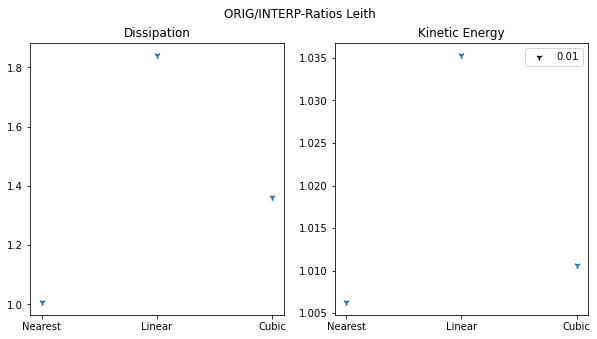

In [27]:
#---
#  Grid001
#---

#- Load total energetics for all starting values
f_ke  = 'total_energetics_ke_interp_Leith_1950_0c01_0c01_0c0083_0c0263' 
f_dis = 'total_energetics_dis_interp_Leith_1950_0c01_0c01_0c0083_0c0263'

dis_interp1, ke_interp1 = data_loader.load_interpolated_total_energetics(f_dis, f_ke, filled=True) #- Starting value 1
dis_interp2, ke_interp2 = data_loader.load_interpolated_total_energetics(f_dis, f_ke, filled=True) # Starting value 2 (Example)

#- Calculate Ratios
ke_interp  = np.concatenate((ke_interp1, 1.0 * ke_interp2,)) # 1.1 as an example if I have different starting values
dis_interp = np.concatenate((dis_interp1, 1.0* dis_interp2,))
ke_ratios  = ke_orig  / ke_interp
dis_ratios = dis_orig / dis_interp

#- Save ratios in dictionary
dict001 = data_manager.create_gridspacing_dict(dis_ratios, ke_ratios)
                       
#- Create dictionary containing all gridspacings
dictionaries  = [dict001,]
grid_spacings = np.array([0.01,])
energy_ratios = data_manager.create_energyratios_dict(dictionaries, grid_spacings)

#- Scatter plot ratios
fig = plotter.scatter_energy_ratios(energy_ratios, scheme)

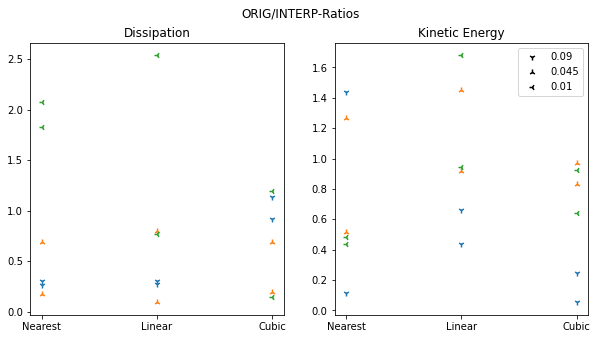

In [120]:
#- Example of scatter plots based on random data. Check this in order to know how to create one.
examples.scatter_plot_ratios()

# Calculation of all necessary quantities for all methods when new data is given

## Load Original Data

In [2]:
#- Modules
import random
import numpy as np
import matplotlib.pyplot as plt

from eddies.data import data_loader
from eddies.data import data_saver

from eddies.grid import FESOM_grid
from eddies.grid import grid_transformer
from eddies.grid import setup_grid

from eddies.interpolation import interpolator
from eddies.interpolation import interpolator
from eddies.interpolation import interpolation_tools

from eddies.diagnostics import spectra
from eddies.diagnostics import energetics

from eddies.figures import plotter

Load 2d part of the grid in 0 second(s)


In [3]:
schemes1 = ['Leith',
           'Easy4',
          ]

schemes2 = ['GAMB_1',
           'GAMB_3',
           'GAMB_7',
           'GAMB_8',
           'GAM4_1', 
           'GAM3_1', 
           'GAM3_4', 
           'GAM2_1', 
           'GAM2_4', 
           'GAM1_3',
          ]

path1 = path_to_model_run1
path2 = path_to_model_run2

years    = [#'1949',
            '1950',
           ]

model_run = 'easy4' # Run for Easy and Leith

In [4]:
%%time
#---------
# Original Data
#---------

#- Parameters
xx0, yy0 = FESOM_grid.elem_x, FESOM_grid.elem_y # Original grid-coordinates
days   = 365       #- Number of days to analyze
lvls   = 1          #- Number of levels to analyze
xx     = xx0[:-228] #- Coordinates Original Grid. Omit last row for interpolation
yy     = yy0[:-228]
dx     = 0.045       #- Grid-Spacing Target Grid
dy     = 0.045
lx     = 4.5        #- Dimensions of Target Grid
ly     = 18.0 
is_hw  = False      #- Effect of hanning window
interp_boarders = True #- If boarder are cut out or filled by nearest neighbours (not with scipy tool) 

#- Setup Target Grid
eps1     = round(random.uniform(0, .09), ndigits=4) # Randomize starting points
eps2     = round(random.uniform(0, .05), ndigits=4)
sx       = 0.0199#eps1 #- Starting points
sy       = 0.0181#eps2
XX1, YY1 = setup_grid.regular_grid(lx=lx, ly=ly, dx=dx, dy=dy, sx=sx, sy=sy) 

methods = ['nearest', 'linear', 'cubic']   #- Interpolation method

CPU times: user 348 µs, sys: 765 µs, total: 1.11 ms
Wall time: 631 µs


In [5]:
#- Create a set of 10 random starting values
starting_values = []  
for i in range(10): 
    sx = round(random.uniform(0, .09), ndigits=4)
    sy = round(random.uniform(0, .05), ndigits=4)
    starting_values.append([sx, sy])

In [7]:
for s in starting_values:
    sx = s[0]
    sy = s[1]
    XX1, YY1 = setup_grid.regular_grid(lx=lx, ly=ly, dx=dx, dy=dy, sx=sx, sy=sy)
    print(f'Starting values sx, sy: {sx, sy}')
    for scheme in schemes1:
        print(f'Diagnostics for scheme: {scheme}')
        for year in years:
            print(f'Diagnostics for year: {year}')

            path = path1 + scheme + '/'
            #- Load Data
            (u, udis, v, vdis) = data_loader.load_original_data(path, year, model_run) # Element-Structure

            #- Interpolate using all methods       
            for method in methods:
                print(f'Interpolating with {method} method')
                #-------
                # Interpolate data
                #-------
                u_int    = interpolator.interpolate_to_grid(u[:,:-228,:], xx, yy, XX1, YY1, days, lvls, method)
                v_int    = interpolator.interpolate_to_grid(v[:,:-228,:], xx, yy, XX1, YY1, days, lvls, method)
                udis_int = interpolator.interpolate_to_grid(udis[:,:-228,:], xx, yy, XX1, YY1, days, lvls, method)
                vdis_int = interpolator.interpolate_to_grid(vdis[:,:-228,:], xx, yy, XX1, YY1, days, lvls, method)

                #-------
                # Treat boarders of NaN values
                #-------
                if interp_boarders:
                    print('Fill Boarders')
                    u_int    = interpolation_tools.fill_boarders(u_int)
                    v_int    = interpolation_tools.fill_boarders(v_int)
                    udis_int = interpolation_tools.fill_boarders(udis_int)
                    vdis_int = interpolation_tools.fill_boarders(vdis_int)
                else:
                    #- Cut NaN Values out
                    print('Cut Boarders')
                    u_int    = interpolation_tools.cut_boarders(u_int)
                    v_int    = interpolation_tools.cut_boarders(v_int)
                    udis_int = interpolation_tools.cut_boarders(udis_int)
                    vdis_int = interpolation_tools.cut_boarders(vdis_int)
                #-------
                # Apply 2D-FFT
                #------- 
                #-------
                # Apply Hanning Window if wanted
                #-------   
                if is_hw: 
                    print('Apply Hanning Window')
                    u_int    = interpolator.apply_hanning_window(u_int   , axis=1)
                    v_int    = interpolator.apply_hanning_window(v_int   , axis=1)
                    udis_int = interpolator.apply_hanning_window(udis_int, axis=1)
                    vdis_int = interpolator.apply_hanning_window(vdis_int, axis=1)

                #- Calculate and collapse 2D-Spectrum
                print('Calculate 2D-Spectra and collapse it')
                (ke, dis, kkarr) = spectra.get_2D_spectrum(u_int, v_int, udis_int, vdis_int)

                #- Save collapsed 2D-Spectrum
                print('Save collapsed spectra')
                folder = '../resources/collapsed_2D_spectra/'
                data_saver.save_collapsed_spectra(ke, dis, year, scheme, dx, dy, sx, sy, folder, method, is_hw, interp_boarders)

                #-------
                # Compare Energetics of Original Grid to Interpolated Grid
                #------- 

                #- Calculate total energetics of interpolated data
                print('Calculate total energetics')
                dis  = energetics.total_dis_interp(u_int, udis_int, v_int, vdis_int, grid_spacing=dx)
                ke   = energetics.total_ke_interp(u_int, v_int, grid_spacing=dx)

                del(u_int, udis_int, v_int, vdis_int)

                #- Save total energetics 
                print('Save total energetics')
                folder  = '../resources/total_energetics_interpolated/'
                data_saver.save_total_energetics_interpolated(ke, dis, year, scheme, dx, dy, sx, sy, folder, method, is_hw, interp_boarders)

            del(u, udis, v, vdis)

## Interpolate to Regular Grid

Note: can only be done for one level.

In [4]:
model_run = 'easy4'
path1 = path_to_your_model_run
year = '1956'
scheme = 'Easy4'
path = path1 + scheme + '/'
(u, udis, v, vdis) = data_loader.load_original_data(path, year, model_run) # Element-Structure

In [8]:

#- Parameters
xx0, yy0 = FESOM_grid.elem_x, FESOM_grid.elem_y # Original grid-coordinates
days   = 365       #- Number of days to analyze
lvls   = 1          #- Number of levels to analyze
xx     = xx0[:-228] #- Coordinates Original Grid. Omit last row for interpolation
yy     = yy0[:-228]
dx     = 0.01       #- Grid-Spacing Target Grid
dy     = 0.01
lx     = 4.5        #- Dimensions of Target Grid
ly     = 18.0 
is_hw  = False      #- Effect of hanning window
interp_boarders = True #- If boarder are cut out or filled by nearest neighbours (not with scipy tool) 

#- Setup Target Grid
eps1     = round(random.uniform(0, .09), ndigits=4) # Randomize starting points
eps2     = round(random.uniform(0, .05), ndigits=4)
sx       = 0.0199#eps1 #- Starting points
sy       = 0.0181 # eps2
XX1, YY1 = setup_grid.regular_grid(lx=lx, ly=ly, dx=dx, dy=dy, sx=sx, sy=sy) 

methods = [#'nearest', 
           #'linear', 
           'cubic',
          ]   #- Interpolation method

for method in methods:
    print(f'Interpolating with {method} method')
    #-------
    # Interpolate data
    #-------
    u_int    = interpolator.interpolate_to_grid(u[:,:-228,:], xx, yy, XX1, YY1, days, lvls, method)
    v_int    = interpolator.interpolate_to_grid(v[:,:-228,:], xx, yy, XX1, YY1, days, lvls, method)
    udis_int = interpolator.interpolate_to_grid(udis[:,:-228,:], xx, yy, XX1, YY1, days, lvls, method)
    vdis_int = interpolator.interpolate_to_grid(vdis[:,:-228,:], xx, yy, XX1, YY1, days, lvls, method)
       
    #-------
    # Treat boarders of NaN values
    #-------
    if interp_boarders:
        u_int    = interpolation_tools.fill_boarders(u_int)
        v_int    = interpolation_tools.fill_boarders(v_int)
        udis_int = interpolation_tools.fill_boarders(udis_int)
        vdis_int = interpolation_tools.fill_boarders(vdis_int)
    else:
        #- Cut NaN Values out
        u_int    = interpolation_tools.cut_boarders(u_int)
        v_int    = interpolation_tools.cut_boarders(v_int)
        udis_int = interpolation_tools.cut_boarders(udis_int)
        vdis_int = interpolation_tools.cut_boarders(vdis_int)
    
    #-------
    # Save interpolated data
    #-------    
    #folder = '../resources/interpolated_data/'
#     f1,f2,f3,f4 = data_saver.save_interpolated_values(u_int, udis_int, v_int, vdis_int, 
#                                                   year=year, scheme=scheme, 
#                                                   dx=dx, dy=dy, sx=sx, sy=sy, 
#                                                   folder=folder, method=method, interp_boarders=interp_boarders
#                                                  )
    #-------
    # Apply 2D-FFT
    #------- 
    #-------
    # Apply Hanning Window if wanted
    #-------   
    if is_hw: 
        print('Apply Hanning Window')
        u_int    = interpolator.apply_hanning_window(u_int   , axis=1)
        v_int    = interpolator.apply_hanning_window(v_int   , axis=1)
        udis_int = interpolator.apply_hanning_window(udis_int, axis=1)
        vdis_int = interpolator.apply_hanning_window(vdis_int, axis=1)

    #- Calculate and collapse 2D-Spectrum
    print('Calculate 2D-Spectra and collapse it')
    (ke, dis, kkarr) = spectra.get_2D_spectrum(u_int, v_int, udis_int, vdis_int)
    
    #- Save collapsed 2D-Spectrum
    print('Save collapsed spectra')
    folder = '../resources/collapsed_2D_spectra/'
    data_saver.save_collapsed_spectra(ke, dis, year, scheme, dx, dy, sx, sy, folder, method, is_hw, interp_boarders)
    
    #-------
    # Compare Energetics of Original Grid to Interpolated Grid
    #------- 
    
    #- Calculate total energetics of interpolated data
    print('Calculate total energetics')
    dis  = energetics.total_dis_interp(u_int, udis_int, v_int, vdis_int, grid_spacing=dx)
    ke   = energetics.total_ke_interp(u_int, v_int, grid_spacing=dx)
    
    del(u_int, udis_int, v_int, vdis_int)
    
    #- Save total energetics 
    print('Save total energetics')
    folder  = '../resources/total_energetics_interpolated/'
    data_saver.save_total_energetics_interpolated(ke, dis, year, scheme, dx, dy, sx, sy, folder, method, is_hw, interp_boarders)